In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib 
import time

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
def normalise(array):
    # ((X - X_min)/(X_max - X_min) * 2) - 1
    min_value = array.min()
    max_value = array.max()
    
    normalised_array = ((array - min_value)/(max_value - min_value) * 2) - 1
    
    return normalised_array

def make_n_dimensional_ndarray(features):
    return np.array(features).transpose()

def normalise_all_columns(ndarray):
    cols = ndarray.shape[1]
    columns = []
    for i in range(cols):
        unnormalised = np.array([element[i] for element in ndarray])
        normalised = normalise(unnormalised)
        columns.append(normalised)
    return np.array(columns).transpose()


In [3]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    padding_ratio = 0.1
    
    x_pad = x_range * padding_ratio
    y_pad = y_range * padding_ratio
    
    x_h = x_range / 1000
    y_h = y_range / 1000
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(
        np.arange(x_min - x_pad, x_max + x_pad, x_h),
        np.arange(y_min - y_pad, y_max + y_pad, y_h)
    )
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.figure(figsize=(20,20))
#     plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.contour(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [29]:
def num_within_xpct(errors, pct_threshold):
    num_within_xpercent =  len([x for x in errors if 0 < x < pct_threshold])
    pct_within_xpercent = (
        num_within_xpercent
        / float( len(errors) )
            ) * 100
    return (pct_within_xpercent, num_within_xpercent)

In [4]:
# Import house price data
melbourne_dtypes = {
    'names':   ('price',   'rooms',   'lat',     'lon',     'date'),
    'formats': ('float32', 'float32', 'float32', 'float32', 'string')
}
melbourne_txns = np.genfromtxt('data/Melbourne_housing_noblanks.csv',
                               #price, rooms, lat, lon, saledate, bedrooms, bathrooms, cars, landsize
                             delimiter=',', usecols=(4,2,17,18,7,10,11,12,13), skip_header=1, 
                             dtype=None
#                              max_rows=total_data_size)
                              )
print(melbourne_txns[1])

training_data_pct = 0.7
test_data_pct = 0.3
total_data_size = len(melbourne_txns)
training_data_size = int(total_data_size * training_data_pct)
test_data_size = int(total_data_size * test_data_pct)

y_prices = np.array([np.float32(txn[0]) for txn in melbourne_txns])
max_price = np.amax(y_prices)

def norm_price(price):
    return (price / (max_price/2)) - 1
def unnorm_price(price):
    return (price + 1)*(max_price/2)

y_norm_prices = norm_price(y_prices)

rooms_unnormalied = np.array([np.float32(txn[1]) for txn in melbourne_txns])
lat_unnormalised = np.array([np.float32(txn[2]) for txn in melbourne_txns])
lon_unnormalised = np.array([np.float32(txn[3]) for txn in melbourne_txns])
saledate_unnormalised = np.array([
    np.float32(int(time.mktime(time.strptime( txn[4], '%d/%m/%Y' )))) for txn in melbourne_txns
])
beds_unnormalised = np.array([np.float32(txn[5]) for txn in melbourne_txns])
baths_unnormalised = np.array([np.float32(txn[6]) for txn in melbourne_txns])
cars_unnormalised = np.array([np.float32(txn[7]) for txn in melbourne_txns])
landsize_unnormalised = np.array([np.float32(txn[8]) for txn in melbourne_txns])

X = normalise_all_columns(
    make_n_dimensional_ndarray(
        [lat_unnormalised,
        lon_unnormalised,
        rooms_unnormalied,
        saledate_unnormalised,
        beds_unnormalised,
        baths_unnormalised,
        cars_unnormalised,
        landsize_unnormalised
        ]
    )
)


X_train = X[0:training_data_size]
X_test = X[training_data_size:total_data_size]

print(X.shape, X_train.shape, X_test.shape)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  if __name__ == '__main__':


(1035000, 2, -37.8079, 144.9934, '4/02/2016', 2, 1, 0, 156)
((20993, 8), (14695, 8), (6298, 8))


In [5]:
# Imports and config
import tensorflow as tf
import numpy as np

num_of_results = y_prices.size
input_layer_size = X_train.shape[1]
hidden_layer_1_size = 100
hidden_layer_2_size = 100
hidden_layer_3_size = 1000
output_layer_size = 1

In [6]:
# Manually-created NN

# Our input layer is the x and y coords
input = tf.placeholder(tf.float32)
target = tf.constant(y_norm_prices)

# Offset in
# offset_in = tf.Variable(tf.random_normal([input_layer_size], 0, 0.1))
# scale_in = tf.Variable(tf.random_normal([input_layer_size], 0, 0.1))
# input_offset = input*scale_in + offset_in
input_offset = input
input_size = tf.to_float(tf.shape(input)[0])

# Weights for mapping input to HL
weights_W1 = tf.Variable( tf.random_normal([input_layer_size, hidden_layer_1_size], 0, 1))
bias_W1 = tf.Variable( tf.random_normal([hidden_layer_1_size], 0, 1))

# Hidden layer 1
# h1 = tf.nn.bias_add(tf.matmul(input, weights_W1), bias_W1)
h1 = tf.nn.bias_add(tf.matmul(input_offset, weights_W1), bias_W1)
h2 = tf.tanh(h1)


# Hidden layer 2
weights_W1b = tf.Variable(tf.random_normal([hidden_layer_1_size, hidden_layer_2_size], 0, 1))
bias_W1b = tf.Variable(tf.random_normal([hidden_layer_2_size], 0, 1))
h3 = tf.nn.bias_add(tf.matmul(h2, weights_W1b), bias_W1b)
h4 = tf.tanh(h3)
# h4 = tf.sigmoid(h3)

# Hidden layer 3
weights_W1c = tf.Variable(tf.random_normal([hidden_layer_2_size, hidden_layer_3_size], 0, 1))
bias_W1c = tf.Variable(tf.random_normal([hidden_layer_3_size], 0, 1))
# h5 = tf.matmul(h4, weights_W1c)
h5 = tf.nn.bias_add(tf.matmul(h4, weights_W1c), bias_W1c)
h6 = tf.tanh(h5)


# Map HL to output
weights_out = tf.Variable(tf.random_normal([hidden_layer_3_size, output_layer_size], 1, 0.5))
bias_out = tf.Variable(tf.random_normal([output_layer_size], 0, 1))
# yhat = tf.nn.bias_add(
#         tf.matmul(h2, weights_W2),
#         bias_W2)
yhat = tf.nn.bias_add(
        tf.matmul(h6, weights_out),
        bias_out)


# Offset out
offset_out = tf.Variable(tf.random_normal([output_layer_size], 1, 0))
scale_out = tf.Variable(tf.random_normal([output_layer_size], 1, 0))
# yhat_out = yhat*scale_out + offset_out
yhat_out = (yhat+offset_out)*scale_out
# yhat_out = yhat


# Compute the error
# yerror = tf.reduce_logsumexp(tf.subtract(yhat, target))
# yerror = tf.reduce_logsumexp(tf.subtract(yhat_out, target))
basic_error = tf.subtract(yhat_out, target)
percent_error = tf.multiply(tf.divide(tf.subtract(yhat_out, target), target), 100)
yerror = tf.divide(basic_error, input_size)
# yerror = yerror_unnormalised
loss = tf.nn.l2_loss(yerror)
# loss = yerror

# Optimise the weights
# update_weights = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
update_weights = tf.train.AdamOptimizer().minimize(loss)

In [30]:
# Train NN and predict

training_steps = 20
epochs = 1000
train_sample_size = 100
test_sample_size = 100

# Output vars
train_losses = []
test_losses = []
error_test_means = []
error_test_stds = []
error_test_highpcts = []
error_test_lowpcts = []
error_test_percenterror_means = []
error_test_percenterror_stds = []
percenterror_test_within10pcts = []
percenterror_test_within20pcts = []

def take_sample(data, size):
    data_size = data.shape[0]
    indexes = np.random.randint(0, high=data_size-1, size=size)
    return data[indexes]

saver = tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for j in range(epochs):
        # Take random samples for training and testing    
        X_test_sample = take_sample(X_test, test_sample_size)
        X_train_sample = take_sample(X_train, train_sample_size)
        
        # Train on sample
        for i in range(training_steps):
            # Train
            sess.run(update_weights, feed_dict = {input: X_train_sample})

        # Losses
        loss_train = loss.eval(feed_dict = {input: X_train_sample})
        train_losses.append(loss_train)           

        loss_test = loss.eval(feed_dict = {input: X_test_sample})
        test_losses.append(loss_test)

        # Error
        error_test = basic_error.eval(feed_dict = {input: X_test_sample})
        error_test = abs(error_test)

        error_test_mean = np.mean(error_test)
        error_test_means.append(error_test_mean)

        error_test_std = np.std(error_test)
        error_test_stds.append(error_test_std)

#         error_test_percentiles = np.percentile(error_test, [25, 27])
#         error_test_highpcts.append(error_test_percentiles[1])
#         error_test_lowpcts.append(error_test_percentiles[0])
        
        percenterror_test = percent_error.eval(feed_dict = {input: X_test_sample})
        percenterror_test = np.ma.masked_invalid( abs(percenterror_test) )
        
        percenterror_test_mean = np.mean( percenterror_test )
        error_test_percenterror_means.append(percenterror_test_mean)
        
        percenterror_test_std = np.std( percenterror_test )
        error_test_percenterror_stds.append(percenterror_test_std)
        
        percenterror_test_within10pct = num_within_xpct(percenterror_test, 10)
        percenterror_test_within10pcts.append(percenterror_test_within10pct)
        
        percenterror_test_within20pct = num_within_xpct(percenterror_test, 20)
        percenterror_test_within20pcts.append(percenterror_test_within20pct)
        
        save_path = saver.save(sess, "./model_longtrain.ckpt")
        
    save_path = saver.save(sess, "./model.ckpt")
    print("Model saved in path: %s" % save_path)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Average error: 0.0831654295325, Standard Dev: 0.0818720683455
Average pct error: 17.8030240091, Standard pct Dev: 233.166883741
Within 10 percent: 63.5718096508
Within 20 percent: 89.6848473301


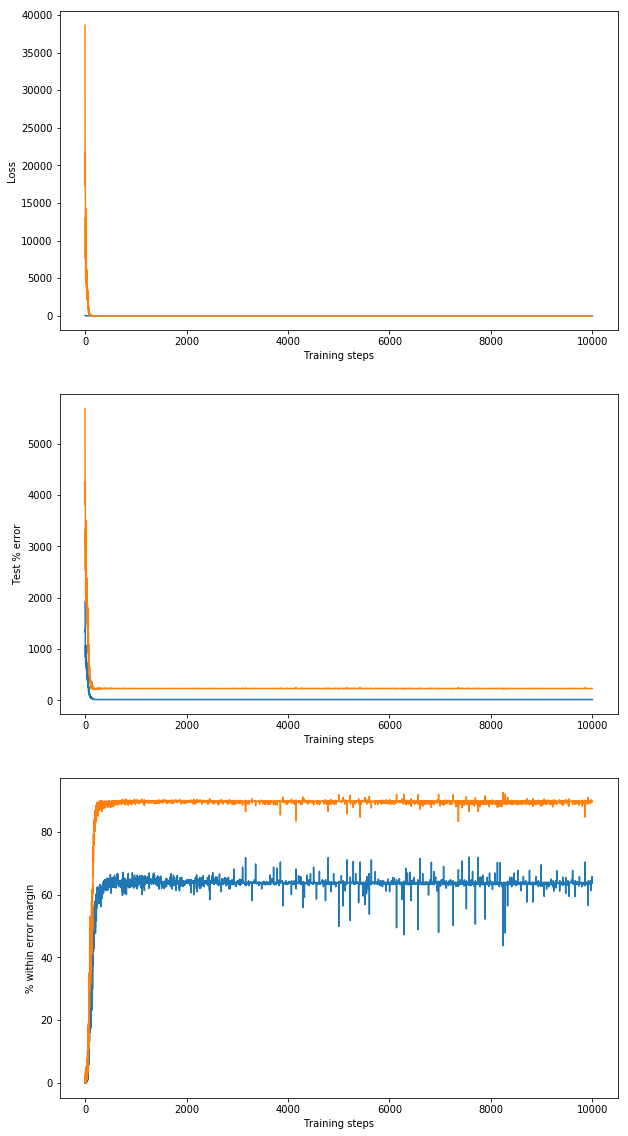

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 20)

# skip=50
skip=0
total_steps = len(train_losses)


# Losses
ax1.plot(range(0, total_steps-skip),
         train_losses[skip:total_steps],
         test_losses[skip:total_steps])
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training steps")


# Errors
# ax2.plot(range(0, total_steps-skip), error_test_means[skip:total_steps])
ax2.plot(range(0, total_steps-skip), error_test_percenterror_means[skip:total_steps])
ax2.plot(range(0, total_steps-skip), error_test_percenterror_stds[skip:total_steps])
# ax2.plot(range(0, total_steps-skip), error_test_lowpcts[skip:total_steps])
# ax2.plot(range(0, total_steps-skip), error_test_highpcts[skip:total_steps])
ax2.set_ylabel("Test % error")
ax2.set_xlabel("Training steps")


ax3.plot(range(0, total_steps-skip), percenterror_test_within10pcts[skip:total_steps])
ax3.plot(range(0, total_steps-skip), percenterror_test_within20pcts[skip:total_steps])
ax3.set_ylabel("% within error margin")
ax3.set_xlabel("Training steps")

# Stats
final_average = error_test_means[-1]
# final_low_pct = error_test_lowpcts[-1]
# final_high_pct = error_test_highpcts[-1]
final_std = error_test_stds[-1]
final_avg_pct_error_mean = error_test_percenterror_means[-1]
final_avg_pct_error_std = error_test_percenterror_stds[-1]
final_avg_10pct = percenterror_test_within10pcts[-1]
final_avg_20pct = percenterror_test_within20pcts[-1]



# Show
print("Average error: {}, Standard Dev: {}".format(
   final_average, final_std))
print("Average pct error: {}, Standard pct Dev: {}".format(
    final_avg_pct_error_mean, final_avg_pct_error_std))
print("Within 10 percent: {}".format(percenterror_test_within10pct))
print("Within 20 percent: {}".format(percenterror_test_within20pct))
plt.show()

In [33]:
# Output some examples
example_size = 1000

actuals = []
predicteds = []
pct_errors = []

with tf.Session() as sess:
  # Restore variables from disk.
    saver.restore(sess, "./model.ckpt")
    print("Model restored.")
    
    def predict(coords):
        return yhat_out.eval(feed_dict = {input: coords})

    examples = take_sample(X_test, example_size)
    predictions = predict(examples)
    
    for i in range(example_size-1):
        actual = y_prices[i]
        predicted = int(unnorm_price(predictions[i]))
        pct_error = abs(int( ((float(predicted) - float(actual)) / float(actual) )* 100 ))
        data = examples[i]
        
        actuals.append(actual)
        predicteds.append(predicted)
        pct_errors.append(pct_error)
        
#         print('Actual: {}, Predicted: {}, Pct_err: {}, X: {}'.format(actual, predicted, pct_error, data) )

avg_pct_err = np.mean(pct_errors)
std_pct_err = np.std(pct_errors)
print("Average % error: {}, STDev: {}".format(avg_pct_err, std_pct_err))

within10pct = num_within_xpct(pct_errors, 10)
print("% within 10% accuracy: {}, or {} total".format(within10pct[0], within10pct[1]))
within20pct = num_within_xpct(pct_errors, 20)
print("% within 20% accuracy: {}, or {} total".format(within20pct[0], within20pct[1]))
within50pct = num_within_xpct(pct_errors, 50)
print("% within 50% accuracy: {}, or {} total".format(within50pct[0], within50pct[1]))


INFO:tensorflow:Restoring parameters from ./model.ckpt
Model restored.
Average % error: 43.4724724725, STDev: 43.0923420451
% within 10% accuracy: 11.7117117117, or 117 total
% within 20% accuracy: 26.8268268268, or 268 total
% within 50% accuracy: 68.2682682683, or 682 total
